In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_APRA_v2.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, CTD_sims)

# Look at all Cs137 data prior to Loma Linda

In [30]:
AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
fullpaths = []
for p in AC_list:
    fullpaths.append(datpath + p)
for p in DC_list:
    fullpaths.append(datpath + p)

## Read in the dat files

In [31]:
Emin = 640.
Emax = 670.

df = make_df_from_dat(fullpaths, e_min=Emin, e_max=Emax)
df

,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z
0,186,11,9,660.713056,160.0,30,659.270938,290.0,1.634266e+307,1.634266e+307,1.634266e+307
1,226,11,14,660.702809,200.0,24,661.478265,155.0,1.634266e+307,1.634266e+307,1.634266e+307
2,339,11,10,659.473632,160.0,11,659.953796,315.0,1.634266e+307,1.634266e+307,1.634266e+307
3,447,11,25,660.205139,220.0,2,662.273650,165.0,1.634266e+307,1.634266e+307,1.634266e+307
4,511,11,31,659.274457,175.0,1,661.487815,200.0,1.634266e+307,1.634266e+307,1.634266e+307
...,...,...,...,...,...,...,...,...,...,...,...
245867,3233815,11,33,661.833776,160.0,27,658.873445,365.0,1.634266e+307,1.634266e+307,1.634266e+307
245868,3233869,11,26,661.762424,275.0,17,662.119364,155.0,1.634266e+307,1.634266e+307,1.634266e+307
245869,3233871,11,27,656.936903,280.0,23,661.620105,150.0,1.634266e+307,1.634266e+307,1.634266e+307
245870,3233925,11,1,663.080791,165.0,15,661.495867,360.0,1.634266e+307,1.634266e+307,1.634266e+307


### Run depth calibration

In [32]:
ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
ctd_obs_flat = []
ctd_stretch_flat = []

for p in range(37):
    for n in range(37):
        ctd_obs, ctd_stretch, depths = calibrator.depth_from_timing(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'])
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depths
        ctd_obs_map[p][n] = ctd_obs
        ctd_stretch_map[p][n] = ctd_stretch
        ctd_obs_flat.append(ctd_obs)
        ctd_stretch_flat.append(ctd_stretch)
        
ctd_obs_flat = np.concatenate(ctd_obs_flat)
ctd_stretch_flat = np.concatenate(ctd_stretch_flat)


sim_depth, sim_ctd = calibrator.get_simdata()

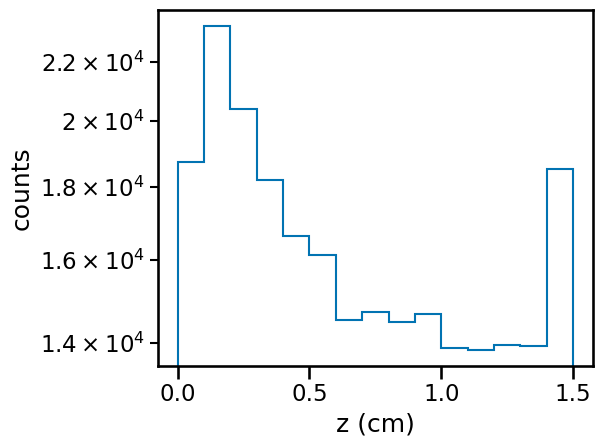

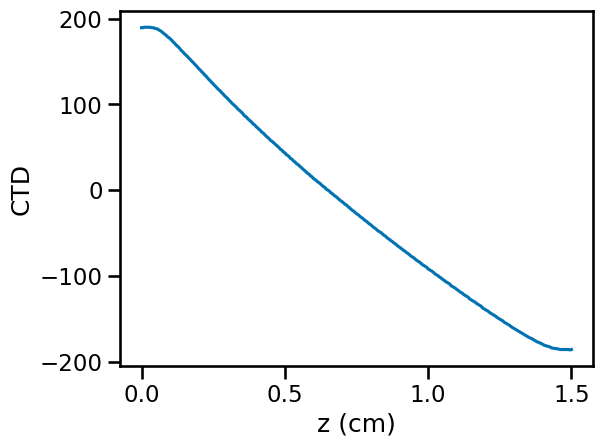

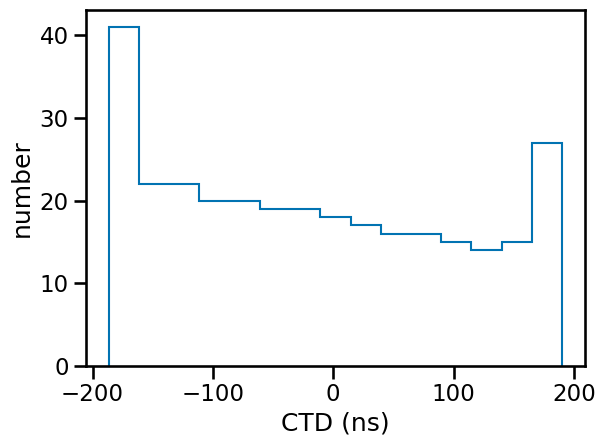

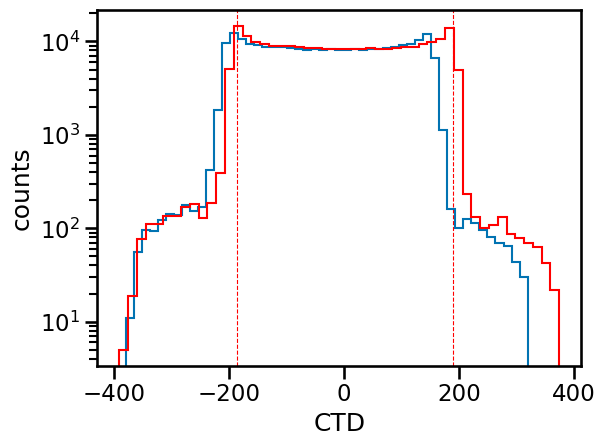

In [33]:
plt.figure()
plt.hist(df["z"], bins=15, histtype = "step", range=(0,1.5))
plt.yscale('log')
plt.xlabel("z (cm)")
plt.ylabel("counts")
plt.tight_layout()
plt.savefig(plot_dir + "Cs137_depth_allACandDC_preLL.pdf")

plt.figure()
plt.plot(sim_depth, sim_ctd)
plt.xlabel('z (cm)')
plt.ylabel('CTD')
plt.tight_layout()
# plt.savefig(plot_dir + "simulated_depth_to_CTD.pdf")

plt.figure()
plt.hist(sim_ctd, bins=15, histtype = "step");
plt.xlabel('CTD (ns)')
plt.ylabel('number')
plt.tight_layout()
# plt.savefig(plot_dir + "simulated_depth_to_CTD.pdf")


plt.figure()
plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
plt.yscale('log')
plt.xlabel('CTD')
plt.ylabel('counts')
plt.tight_layout()
plt.savefig(plot_dir + "Cs137_CTD_allACandDC_preLL.pdf")

In [34]:
z_min = 0.0     # cm
z_max = 1.5
num_z=26
z_bins = np.arange(z_min,z_max + (z_max-z_min)/num_z,(z_max-z_min)/num_z)
print(z_bins)
df["z_binned"] = pd.cut(df["z"],bins=z_bins)
df


[0.         0.05769231 0.11538462 0.17307692 0.23076923 0.28846154
 0.34615385 0.40384615 0.46153846 0.51923077 0.57692308 0.63461538
 0.69230769 0.75       0.80769231 0.86538462 0.92307692 0.98076923
 1.03846154 1.09615385 1.15384615 1.21153846 1.26923077 1.32692308
 1.38461538 1.44230769 1.5       ]


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_binned
0,186,11,9,660.713056,160.0,30,659.270938,290.0,1.634266e+307,1.634266e+307,1.105059,"(1.096, 1.154]"
1,226,11,14,660.702809,200.0,24,661.478265,155.0,1.634266e+307,1.634266e+307,0.444133,"(0.404, 0.462]"
2,339,11,10,659.473632,160.0,11,659.953796,315.0,1.634266e+307,1.634266e+307,1.077890,"(1.038, 1.096]"
3,447,11,25,660.205139,220.0,2,662.273650,165.0,1.634266e+307,1.634266e+307,0.352445,"(0.346, 0.404]"
4,511,11,31,659.274457,175.0,1,661.487815,200.0,1.634266e+307,1.634266e+307,0.630581,"(0.577, 0.635]"
...,...,...,...,...,...,...,...,...,...,...,...,...
245867,3233815,11,33,661.833776,160.0,27,658.873445,365.0,1.634266e+307,1.634266e+307,1.470000,"(1.442, 1.5]"
245868,3233869,11,26,661.762424,275.0,17,662.119364,155.0,1.634266e+307,1.634266e+307,0.163783,"(0.115, 0.173]"
245869,3233871,11,27,656.936903,280.0,23,661.620105,150.0,1.634266e+307,1.634266e+307,0.194185,"(0.173, 0.231]"
245870,3233925,11,1,663.080791,165.0,15,661.495867,360.0,1.634266e+307,1.634266e+307,1.470000,"(1.442, 1.5]"


## Fit the spectra depth bin by depth bin

In [35]:
z_list = []
centroid_list = []
centroid_err_list = []

tail_cnts = []
gauss_cnts = []
tail_frac = []

fig, axes = plt.subplots(figsize = (12, num_z*2.), nrows=num_z*2, ncols=2, sharex=True, sharey='row', \
                        gridspec_kw={'hspace':0, 'wspace':0, 'height_ratios':np.array([(2,1) for i in range(num_z)]).flatten()})
for i in range(num_z):
    
    label = "{}-{} cm".format(round(z_bins[i], 1),round(z_bins[i+1], 1))

    # fit both sides
    temp_x0 = []
    temp_x0_err = []
    for j, side in enumerate(['p', 'n']):
        if side=='p':
            carrier='electron'
        else:
            carrier='hole'

        ax = axes[i*2][j]
        resid_ax = axes[(i*2)+1][j]            
        color = 'C' + str(j)

        energies = df.loc[df.z.le(z_bins[i+1])&df.z.gt(z_bins[i]), 'energy_'+side].values
        hist,binedges,_ = ax.hist(energies, histtype="step",color=color,bins=100,label=carrier + " signal, " + label)

        bin_centers = np.array((binedges[:-1] + binedges[1:]) / 2)

        c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

        m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=Emin, Emax=Emax)
        m.limits["x0"] = (650., 672.)
        m.limits["BoverA", "sigma_gauss"] = (0, None)
        m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
        m.migrad()
        m.hesse()

        BoverA, x0, sigma_gauss = m.values[:3]
        A = np.sum(hist)*(bin_centers[1]-bin_centers[0])/\
            quad(gauss_plus_tail, np.min(energies), np.max(energies), args = (BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_D, global_sigma_ratio))[0]
        # print(m.values)
        # print(m.errors['x0'])
        temp_x0.append(m.values['x0'])
        temp_x0_err.append(m.errors['x0'])
        # print(c(*m.values))
        # print(np.sum(np.log(gauss_plus_tail_pdf(df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, *m.values))))
        B = A*BoverA
        C = B*global_CoverB

        ax.plot(bin_centers,A*gauss_plus_tail(bin_centers, BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_D, global_sigma_ratio),color= color, lw=0.5)
        resid_ax.errorbar(bin_centers[hist>0], \
                           (hist[hist>0] - A*gauss_plus_tail(bin_centers[hist>0],BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_D, global_sigma_ratio))/np.sqrt(hist[hist>0]), \
                           xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
        ax.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, B*exp_tail(bin_centers, x0, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, C*linear_tail(bin_centers, x0, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.axvline(x0, ls='--', color='C3')
        ax.axvline(Cs_line, ls='--', color='C2')
        if j==0:
            ax.set_ylabel("Counts")
        ax.set_yscale('log')
        ax.set_ylim((1, 10000))
        ax.legend(loc=2, fontsize=12)
        resid_ax.axhline(0, color='red', lw=0.5)

    # temp_tail_cnts = []
    # temp_gauss_cnts = []
    # temp_tail_frac = []
    # for temp_popt in np.random.multivariate_normal(popt_p, pcov_p, size=1000):
    #     A, BoverA, x0, sigma_gauss = temp_popt
    #     B = A*BoverA
    #     C = B*global_CoverB
    #     temp_tail_cnts.append(B*quad(exp_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_gamma))[0] + \
    #                       C*quad(linear_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_D))[0])
    #     temp_gauss_cnts.append(A*quad(gaussian, 630,800, args = (x0, sigma_gauss))[0])
    #     temp_tail_frac.append(temp_tail_cnts[-1]/(temp_tail_cnts[-1] + temp_gauss_cnts[-1]))
    # tail_cnts_p.append([np.mean(temp_tail_cnts), np.std(temp_tail_cnts)])
    # gauss_cnts_p.append([np.mean(temp_gauss_cnts), np.std(temp_gauss_cnts)])
    # tail_frac_p.append([np.mean(temp_tail_frac), np.std(temp_tail_frac)])


    axes[(i*2)+1][0].set_ylabel(r'$\chi$')
    centroid_list.append(temp_x0)
    centroid_err_list.append(temp_x0_err)

axes[-1][0].set_xlim(Emin,Emax)
axes[-1][1].set_xlim(Emin,Emax)
axes[-1][0].set_xlabel("Energy (keV)")
axes[-1][1].set_xlabel("Energy (keV)")
plt.tight_layout()

plt.savefig(plot_dir + 'zplitspectra_uncorr_allACandDC_preLL.pdf')
plt.close()

In [36]:
centroid_list = np.array(centroid_list)
centroid_err_list = np.array(centroid_err_list)
plt.figure()
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_list.T[0],xerr = z_max/(num_z*2.), yerr=centroid_err_list.T[0],fmt=".",label="electron signal")
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_list.T[1],xerr = z_max/(num_z*2.), yerr=centroid_err_list.T[1],fmt=".",label="hole signal")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=4)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'e_hole_trapping_allACandDC_preLL.pdf')
plt.close()

centroid_pre = centroid_list
centroid_err_pre = centroid_err_list

# Do the same for the data after LL round 1

In [37]:
AC_list = ['20231030_Cs137_AC_600V.dat', '20231031_Cs137_AC_600V.dat', '20231101_Cs137_AC_600V.dat', '20231102_Cs137_AC_600V_1.dat', '20231102_Cs137_AC_600V_2.dat']
DC_list = ['20231030_Cs137_DC_600V_1.dat', '20231030_Cs137_DC_600V_2.dat', '20231031_Cs137_DC_600V.dat', '20231101_Cs137_DC_600V_1.dat', '20231101_Cs137_DC_600V_2.dat', '20231102_Cs137_DC_600V.dat']
fullpaths = []
for p in AC_list:
    fullpaths.append(datpath + p)
for p in DC_list:
    fullpaths.append(datpath + p)

## Read in the dat files

In [38]:
Emin = 640.
Emax = 670.

df = make_df_from_dat(fullpaths, e_min=Emin, e_max=Emax)
df

,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z
0,3291,11,12,650.309797,190.0,17,647.425530,260.0,1.634266e+307,1.634266e+307,1.634266e+307
1,3539,11,12,658.648076,185.0,5,649.086413,250.0,1.634266e+307,1.634266e+307,1.634266e+307
2,4110,11,12,667.218569,180.0,35,654.353307,205.0,1.634266e+307,1.634266e+307,1.634266e+307
3,4200,11,12,665.597080,190.0,36,655.477797,175.0,1.634266e+307,1.634266e+307,1.634266e+307
4,4374,11,12,667.450212,250.0,18,654.014595,150.0,1.634266e+307,1.634266e+307,1.634266e+307
...,...,...,...,...,...,...,...,...,...,...,...
346055,2841169,11,37,659.665722,240.0,29,657.320119,145.0,1.634266e+307,1.634266e+307,1.634266e+307
346056,2841403,11,21,662.615050,170.0,33,660.963771,270.0,1.634266e+307,1.634266e+307,1.634266e+307
346057,2841404,11,3,658.141903,170.0,31,660.687238,180.0,1.634266e+307,1.634266e+307,1.634266e+307
346058,2841534,11,16,661.181029,155.0,18,654.014595,275.0,1.634266e+307,1.634266e+307,1.634266e+307


### Run depth calibration

In [39]:
ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
ctd_obs_flat = []
ctd_stretch_flat = []

for p in range(37):
    for n in range(37):
        ctd_obs, ctd_stretch, depths = calibrator.depth_from_timing(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'])
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depths
        ctd_obs_map[p][n] = ctd_obs
        ctd_stretch_map[p][n] = ctd_stretch
        ctd_obs_flat.append(ctd_obs)
        ctd_stretch_flat.append(ctd_stretch)
        
ctd_obs_flat = np.concatenate(ctd_obs_flat)
ctd_stretch_flat = np.concatenate(ctd_stretch_flat)

sim_depth, sim_ctd = calibrator.get_simdata()

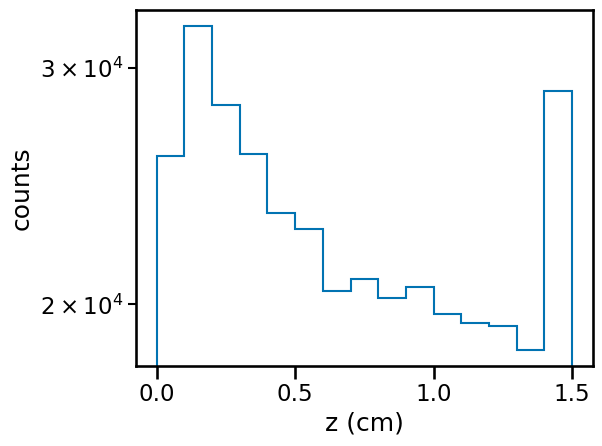

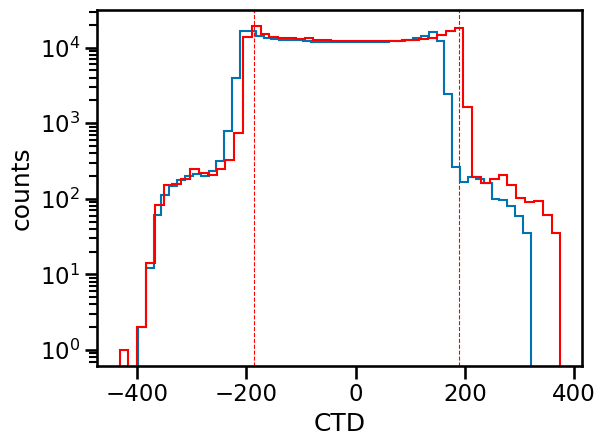

In [40]:
plt.figure()
plt.hist(df["z"], bins=15, histtype = "step", range=(0,1.5));
plt.yscale('log')
plt.xlabel("z (cm)")
plt.ylabel("counts")
plt.tight_layout()
plt.savefig(plot_dir + "Cs137_depth_allACandDC_postLL1.pdf")

plt.figure()
plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
plt.yscale('log')
plt.xlabel('CTD')
plt.ylabel('counts')
plt.tight_layout()
plt.savefig(plot_dir + "Cs137_CTD_allACandDC_postLL1.pdf")

In [41]:
z_min = 0.0     # cm
z_max = 1.5
num_z=26
z_bins = np.arange(z_min,z_max + (z_max-z_min)/num_z,(z_max-z_min)/num_z)
print(z_bins)
df["z_binned"] = pd.cut(df["z"],bins=z_bins)
df


[0.         0.05769231 0.11538462 0.17307692 0.23076923 0.28846154
 0.34615385 0.40384615 0.46153846 0.51923077 0.57692308 0.63461538
 0.69230769 0.75       0.80769231 0.86538462 0.92307692 0.98076923
 1.03846154 1.09615385 1.15384615 1.21153846 1.26923077 1.32692308
 1.38461538 1.44230769 1.5       ]


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_binned
0,3291,11,12,650.309797,190.0,17,647.425530,260.0,1.634266e+307,1.634266e+307,0.800402,"(0.75, 0.808]"
1,3539,11,12,658.648076,185.0,5,649.086413,250.0,1.634266e+307,1.634266e+307,0.788681,"(0.75, 0.808]"
2,4110,11,12,667.218569,180.0,35,654.353307,205.0,1.634266e+307,1.634266e+307,0.652747,"(0.635, 0.692]"
3,4200,11,12,665.597080,190.0,36,655.477797,175.0,1.634266e+307,1.634266e+307,0.475065,"(0.462, 0.519]"
4,4374,11,12,667.450212,250.0,18,654.014595,150.0,1.634266e+307,1.634266e+307,0.225956,"(0.173, 0.231]"
...,...,...,...,...,...,...,...,...,...,...,...,...
346055,2841169,11,37,659.665722,240.0,29,657.320119,145.0,1.634266e+307,1.634266e+307,0.254587,"(0.231, 0.288]"
346056,2841403,11,21,662.615050,170.0,33,660.963771,270.0,1.634266e+307,1.634266e+307,0.954574,"(0.923, 0.981]"
346057,2841404,11,3,658.141903,170.0,31,660.687238,180.0,1.634266e+307,1.634266e+307,0.502401,"(0.462, 0.519]"
346058,2841534,11,16,661.181029,155.0,18,654.014595,275.0,1.634266e+307,1.634266e+307,0.983460,"(0.981, 1.038]"


## Fit the spectra depth bin by depth bin

In [42]:
z_list = []
centroid_list = []
centroid_err_list = []

tail_cnts = []
gauss_cnts = []
tail_frac = []

fig, axes = plt.subplots(figsize = (12, 2*num_z), nrows=num_z*2, ncols=2, sharex=True, sharey='row', \
                        gridspec_kw={'hspace':0, 'wspace':0, 'height_ratios':np.array([(2,1) for i in range(num_z)]).flatten()})
for i in range(num_z):
    
    label = "{}-{} cm".format(round(z_bins[i], 1),round(z_bins[i+1], 1))

    # fit both sides
    temp_x0 = []
    temp_x0_err = []
    for j, side in enumerate(['p', 'n']):
        if side=='p':
            carrier='electron'
        else:
            carrier='hole'

        ax = axes[i*2][j]
        resid_ax = axes[(i*2)+1][j]            
        color = 'C' + str(j)

        energies = df.loc[df.z.le(z_bins[i+1])&df.z.gt(z_bins[i]), 'energy_'+side].values
        hist,binedges,_ = ax.hist(energies, histtype="step",color=color,bins=100,label=carrier + " signal, " + label)

        bin_centers = np.array((binedges[:-1] + binedges[1:]) / 2)

        c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

        m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=Emin, Emax=Emax)
        m.limits["x0"] = (Emin, Emax)
        m.limits["BoverA", "sigma_gauss"] = (0, None)
        m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
        m.migrad()
        m.hesse()

        BoverA, x0, sigma_gauss = m.values[:3]
        A = np.sum(hist)*(bin_centers[1]-bin_centers[0])/\
            quad(gauss_plus_tail, np.min(energies), np.max(energies), args = (BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_D, global_sigma_ratio))[0]
        # print(m.values)
        # print(m.errors['x0'])
        temp_x0.append(m.values['x0'])
        temp_x0_err.append(m.errors['x0'])
        # print(c(*m.values))
        # print(np.sum(np.log(gauss_plus_tail_pdf(df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, *m.values))))
        B = A*BoverA
        C = B*global_CoverB

        ax.plot(bin_centers,A*gauss_plus_tail(bin_centers, BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_D, global_sigma_ratio),color= color, lw=0.5)
        resid_ax.errorbar(bin_centers[hist>0], \
                           (hist[hist>0] - A*gauss_plus_tail(bin_centers[hist>0],BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_D, global_sigma_ratio))/np.sqrt(hist[hist>0]), \
                           xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
        ax.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, B*exp_tail(bin_centers, x0, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, C*linear_tail(bin_centers, x0, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.axvline(x0, ls='--', color='C3')
        ax.axvline(Cs_line, ls='--', color='C2')
        if j==0:
            ax.set_ylabel("Counts")
        ax.set_yscale('log')
        ax.set_ylim((1, 10000))
        ax.legend(loc=2, fontsize=12)
        resid_ax.axhline(0, color='red', lw=0.5)

    # temp_tail_cnts = []
    # temp_gauss_cnts = []
    # temp_tail_frac = []
    # for temp_popt in np.random.multivariate_normal(popt_p, pcov_p, size=1000):
    #     A, BoverA, x0, sigma_gauss = temp_popt
    #     B = A*BoverA
    #     C = B*global_CoverB
    #     temp_tail_cnts.append(B*quad(exp_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_gamma))[0] + \
    #                       C*quad(linear_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_D))[0])
    #     temp_gauss_cnts.append(A*quad(gaussian, 630,800, args = (x0, sigma_gauss))[0])
    #     temp_tail_frac.append(temp_tail_cnts[-1]/(temp_tail_cnts[-1] + temp_gauss_cnts[-1]))
    # tail_cnts_p.append([np.mean(temp_tail_cnts), np.std(temp_tail_cnts)])
    # gauss_cnts_p.append([np.mean(temp_gauss_cnts), np.std(temp_gauss_cnts)])
    # tail_frac_p.append([np.mean(temp_tail_frac), np.std(temp_tail_frac)])


    axes[(i*2)+1][0].set_ylabel(r'$\chi$')
    centroid_list.append(temp_x0)
    centroid_err_list.append(temp_x0_err)

axes[-1][0].set_xlim(Emin,Emax)
axes[-1][1].set_xlim(Emin,Emax)
axes[-1][0].set_xlabel("Energy (keV)")
axes[-1][1].set_xlabel("Energy (keV)")
plt.tight_layout()

plt.savefig(plot_dir + 'zplitspectra_uncorr_allACandDC_postLL1.pdf')
plt.close()

In [43]:
centroid_list = np.array(centroid_list)
centroid_err_list = np.array(centroid_err_list)
plt.figure()
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_list.T[0],xerr = z_max/(num_z*2.), yerr=centroid_err_list.T[0],fmt=".",label="electron signal")
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_list.T[1],xerr = z_max/(num_z*2.), yerr=centroid_err_list.T[1],fmt=".",label="hole signal")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=3)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'e_hole_trapping_allACandDC_postLL1.pdf')
plt.close()

centroid_post = centroid_list
centroid_err_post = centroid_err_list

In [48]:
plt.figure()
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_pre.T[0],xerr = z_max/(num_z*2.), yerr=centroid_err_pre.T[0],fmt=".",label="undamaged")
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_post.T[0],xerr = z_max/(num_z*2.), yerr=centroid_err_post.T[0],fmt=".",label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=4)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'e_trapping_before_after.pdf')
plt.close()

plt.figure()
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_pre.T[1],xerr = z_max/(num_z*2.), yerr=centroid_err_pre.T[1],fmt=".", label="undamaged")
plt.errorbar((z_bins[:-1]+z_bins[1:])/2,centroid_post.T[1],xerr = z_max/(num_z*2.), yerr=centroid_err_post.T[1],fmt=".", label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=3)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'hole_trapping_before_after.pdf')
plt.close()


In [7]:
### Correct the spectra on each side, separately.
z_corr_factor = {"p": Cs_line/np.array(centroid_list.T[0]), "n": Cs_line/np.array(centroid_list.T[1])}

# xs = np.linspace(650, 672, int(1e6))
for j, side in enumerate(z_corr_factor):
    print(side + '-side')
    color = 'C' + str(j)

    uncorr_energies = []
    corr_energies = []

    for i in range(num_z):

        z = z_freq_depthsort[i]
        z_cm = z_bins[z]

        uncorr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values)
        corr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values * z_corr_factor[side][i])

    uncorr_energies = np.concatenate(uncorr_energies)
    corr_energies = np.concatenate(corr_energies)

    uncorr_energies = uncorr_energies[uncorr_energies > 645.]
    corr_energies = corr_energies[corr_energies > 645.]

    plt.figure(figsize=(9,6))
    hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
    hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

    # Plot uncorrected data
    bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
    c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio)
    m.limits["x0"] = (Emin., Emax.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, np.min(uncorr_energies), np.max(uncorr_energies), args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Uncorrected FWHM: ", 2.355*m.values['sigma_gauss'])

    temp_sigma_uncorr = m.values['sigma_gauss']

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C3')


    # Next plot corrected data
    bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
    c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio)
    m.limits["x0"] = (650., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, np.min(corr_energies), np.max(corr_energies), args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Corrected FWHM: ", 2.355*m.values['sigma_gauss'])

    temp_sigma_corr = m.values['sigma_gauss']
    print('Delta FWHM:', 2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)))
    print('1 - Corrected centroid/Cs_line:', 1. - m.values['x0']/Cs_line)

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C2')


    if side =='p':
        plt.text(646, np.max(hist_corr)*0.1, 'electron signal', color='C0', fontsize=24)
    else:
        plt.text(646, np.max(hist_corr)*0.1, 'hole signal', color='C1', fontsize=24)


    plt.ylabel("Counts")
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.ylim((5, np.max(hist_corr)*1.5))
    plt.xlim(645.,666.5)
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_' + side + '.pdf')
    plt.close()

### Produce corrected spectra averaging between sides
uncorr_energies = []
corr_energies = []

# xs = np.linspace(650, 672, int(1e6))
for i in range(num_z):

    z = z_freq_depthsort[i]
    z_cm = z_bins[z]

    uncorr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, \
                                    df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values], axis=0))
    corr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values * z_corr_factor["p"][i], \
                                  df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values * z_corr_factor["n"][i]], axis=0))
uncorr_energies = np.concatenate(uncorr_energies)
corr_energies = np.concatenate(corr_energies)


uncorr_energies = uncorr_energies[uncorr_energies > 652.]
corr_energies = corr_energies[corr_energies > 652.]

plt.figure(figsize=(9,6))
hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

print('----Combined signal----')
# Plot uncorrected data
bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio)
m.limits["x0"] = (640., 672.)
m.limits["BoverA", "sigma_gauss"] = (0, None)
m.fixed["gamma", "CoverB", "D", "sigma_ratio"] = True
m.migrad()
m.hesse()

BoverA, x0, sigma_gauss = m.values[:3]
A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
    quad(gauss_plus_tail, np.min(uncorr_energies), np.max(uncorr_energies), args = (1.0, BoverA, x0, sigma_gauss))[0]
# print(m.values)
# print(m.errors['x0'])
B = A*BoverA
C = B*global_CoverB

print("Uncorrected FWHM: ", 2.355*m.values['sigma_gauss'])
temp_sigma_uncorr = m.values['sigma_gauss']

# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
# roots = spline.roots() # find the roots
# fwhm_uncorr=roots[1] - roots[0]
# print("uncorrected FWHM: " + str(roots[1] - roots[0]))
# plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
#          color='C3', fontsize=20)
# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
# roots = spline.roots() # find the roots
# print("uncorrected FWTM: " + str(roots[1] - roots[0]))


plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
# resid_ax.errorbar(bin_centers[hist>0], \
#                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
#                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
plt.axvline(m.values['x0'], ls='--', color='C3')


# Next plot corrected data
bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio)
m.limits["x0"] = (650., 672.)
m.limits["BoverA", "sigma_gauss"] = (0, None)
m.fixed["gamma", "CoverB", "D", "sigma_ratio"] = True
m.migrad()
m.hesse()

BoverA, x0, sigma_gauss = m.values[:3]
A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
    quad(gauss_plus_tail, np.min(corr_energies), np.max(corr_energies), args = (1.0, BoverA, x0, sigma_gauss))[0]
# print(m.values)
# print(m.errors['x0'])
B = A*BoverA
C = B*global_CoverB

print("Corrected FWHM: ", 2.355*m.values['sigma_gauss'])

temp_sigma_corr = m.values['sigma_gauss']

print('Delta FWHM:', 2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)))
print('1 - Corrected centroid/Cs_line:', 1. - m.values['x0']/Cs_line)

# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
# roots = spline.roots() # find the roots
# fwhm_uncorr=roots[1] - roots[0]
# print("uncorrected FWHM: " + str(roots[1] - roots[0]))
# plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
#          color='C3', fontsize=20)
# spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
# roots = spline.roots() # find the roots
# print("uncorrected FWTM: " + str(roots[1] - roots[0]))


plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
# resid_ax.errorbar(bin_centers[hist>0], \
#                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
#                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
plt.axvline(m.values['x0'], ls='--', color='C2')
# plt.axvline(Cs_line, ls='--', color = 'cyan')

# plt.text(653., np.max(hist_corr)*0.3, r'$e^-\ \mathrm{and}\ h^+$', color='black', fontsize=24)
plt.ylabel("Counts")
plt.yscale('log')
plt.ylim((40., np.max(hist_corr)*1.5))
plt.xlim(652.,665.)
plt.xlabel('Energy (keV)')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_bothsides.pdf')
plt.close()

Det  2
p-side
Uncorrected FWHM:  2.782624738954863
Corrected FWHM:  2.558371872144271
Delta FWHM: 1.0944102529054804
1 - Corrected centroid/Cs_line: 3.8708255238439904e-05
n-side
Uncorrected FWHM:  2.647871035453572
Corrected FWHM:  2.6156678102539157
Delta FWHM: 0.4117073314813054
1 - Corrected centroid/Cs_line: 3.266199106399803e-05
----Combined signal----
Uncorrected FWHM:  2.2362045459092754
Corrected FWHM:  2.169592795509419
Delta FWHM: 0.5417359807313273
1 - Corrected centroid/Cs_line: 0.00020745470918270836
Det  4
p-side
Uncorrected FWHM:  3.0445822374720874
Corrected FWHM:  2.929911817351353
Delta FWHM: 0.8277063146282224
1 - Corrected centroid/Cs_line: 3.88613286671502e-05
n-side
Uncorrected FWHM:  2.8727212372783004
Corrected FWHM:  2.8383144564399916
Delta FWHM: 0.44328134798739743
1 - Corrected centroid/Cs_line: 3.170063577317972e-05
----Combined signal----
Uncorrected FWHM:  2.4008241637444936
Corrected FWHM:  2.3757263435433926
Delta FWHM: 0.3462383656000437
1 - Corrected

# Perform correction using spline

In [13]:
pnflipped = [True, True, True, False, False, False, True, True, True, False, False, False]
det_layers = [2,1,0,0,1,2,2,1,0,0,1,2]
# dets = [0,1,2,3,4,5,6,7,8,9,10,11]
dets=[2,4,8]
# 11 has high-E excess, messing up fits. 5,6, 10 have low-E bump. 0 and 1 have wiggles near the peak.
# 9 is really broad on the hole signal
# Best-looking fits: 2, 4, 8

for det in dets:
    print('Det ', det)

    df_dat_det = df_dat[df_dat["det"]==det]
    z_binned_freq_values = df_dat_det["z_binned"].value_counts().index.to_list()

    z_list = []
    centroid_list = []
    centroid_err_list = []
    centroid_hull = []
    centroid_err_hull = []

    tail_cnts = []
    gauss_cnts = []
    tail_frac = []

    z_freq_depthsort = np.sort(z_binned_freq_values[:num_z])
    
    if pnflipped[det]:
        top = det_edges[det_layers[det]][0]
    else:
        top = det_edges[det_layers[det]][1]


    fig, axes = plt.subplots(figsize = (12, 30), nrows=num_z*2, ncols=2, sharex=True, sharey='row', \
                            gridspec_kw={'hspace':0, 'wspace':0, 'height_ratios':np.array([(2,1) for i in range(num_z)]).flatten()})
    for i in range(num_z):
        
        z = z_freq_depthsort[i]
        z_list.append(z)
        
        if pnflipped[det]:
            label = "depth bin {} = {}-{} cm".format(z,round(z_bins[z]-top,2),round(z_bins[z+1]-top,2))
        else:
            label = "depth bin {} = {}-{} cm".format(z,round(top - z_bins[z],2),round(top - z_bins[z+1],2))
        
        # fit both sides
        temp_x0 = []
        temp_x0_err = []
        for j, side in enumerate(['p', 'n']):
            if side=='p':
                carrier='electron'
            else:
                carrier='hole'
                
            ax = axes[i*2][j]
            resid_ax = axes[(i*2)+1][j]            
            color = 'C' + str(j)
            
            energies = df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values
            hist,binedges,_ = ax.hist((df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values),
                                       histtype="step",color=color,bins=100,label=carrier + " signal, " + label)

            bin_centers = np.array((binedges[:-1] + binedges[1:]) / 2)

            c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

            m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
                       Emin=640., Emax=672.)
            m.limits["x0"] = (650., 672.)
            m.limits["BoverA", "sigma_gauss"] = (0, None)
            m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
            m.migrad()
            m.hesse()

            BoverA, x0, sigma_gauss = m.values[:3]
            A = np.sum(hist)*(bin_centers[1]-bin_centers[0])/\
                quad(gauss_plus_tail, 640., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
            # print(m.values)
            # print(m.errors['x0'])
            temp_x0.append(m.values['x0'])
            temp_x0_err.append(m.errors['x0'])
            # print(c(*m.values))
            # print(np.sum(np.log(gauss_plus_tail_pdf(df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, *m.values))))
            B = A*BoverA
            C = B*global_CoverB
            
            ax.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
            resid_ax.errorbar(bin_centers[hist>0], \
                               (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
                               xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
            ax.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color= color, ls='--', lw=0.5)
            ax.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
            ax.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
            ax.axvline(x0, ls='--', color='C3')
            ax.axvline(Cs_line, ls='--', color='C2')
            if j==0:
                ax.set_ylabel("Counts")
            ax.set_yscale('log')
            ax.set_ylim((0.1, 4000))
            ax.legend(loc=2, fontsize=12)
            resid_ax.axhline(0, color='red', lw=0.5)

            # temp_tail_cnts = []
            # temp_gauss_cnts = []
            # temp_tail_frac = []
            # for temp_popt in np.random.multivariate_normal(popt_p, pcov_p, size=1000):
            #     A, BoverA, x0, sigma_gauss = temp_popt
            #     B = A*BoverA
            #     C = B*global_CoverB
            #     temp_tail_cnts.append(B*quad(exp_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_gamma))[0] + \
            #                       C*quad(linear_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_D))[0])
            #     temp_gauss_cnts.append(A*quad(gaussian, 630,800, args = (x0, sigma_gauss))[0])
            #     temp_tail_frac.append(temp_tail_cnts[-1]/(temp_tail_cnts[-1] + temp_gauss_cnts[-1]))
            # tail_cnts_p.append([np.mean(temp_tail_cnts), np.std(temp_tail_cnts)])
            # gauss_cnts_p.append([np.mean(temp_gauss_cnts), np.std(temp_gauss_cnts)])
            # tail_frac_p.append([np.mean(temp_tail_frac), np.std(temp_tail_frac)])
        
                                         
        axes[(i*2)+1][0].set_ylabel(r'$\chi$')
        centroid_list.append(temp_x0)
        centroid_err_list.append(temp_x0_err)
        
        ### For each depth, also calculate the centroid for the mean anode and cathode energies.
        energies = np.mean([df_dat_det[df_dat_det["z_binned"]==z]['energy_p'].values, df_dat_det[df_dat_det["z_binned"]==z]['energy_n'].values], axis=0)
        c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

        m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
                   Emin=640., Emax=672.)
        m.limits["x0"] = (650., 672.)
        m.limits["BoverA", "sigma_gauss"] = (0, None)
        m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
        m.migrad()
        m.hesse()

        # BoverA, x0, sigma_gauss = m.values[:3]
        # A = np.sum(hist)*(bin_centers[1]-bin_centers[0])/\
        #     quad(gauss_plus_tail, np.min(energies), np.max(energies), args = (1.0, BoverA, x0, sigma_gauss))[0]
        # print(m.values)
        # print(m.errors['x0'])
        centroid_hull.append(m.values['x0'])
        centroid_err_hull.append(m.errors['x0'])
        # print(c(*m.values))
        # print(np.sum(np.log(gauss_plus_tail_pdf(df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, *m.values))))
        # B = A*BoverA
        # C = B*global_CoverB


    axes[-1][0].set_xlim(Emin,666.5)
    axes[-1][1].set_xlim(Emin,666.5)
    axes[-1][0].set_xlabel("Energy (keV)")
    axes[-1][1].set_xlabel("Energy (keV)")
    plt.tight_layout()

    plt.savefig(plot_dir + 'zplitspectra_uncorr_' +str(det) + '.pdf')
    plt.close()
    

    centroid_list = np.array(centroid_list)
    centroid_err_list = np.array(centroid_err_list)
    
    splines = {'p': UnivariateSpline(z_bins[z_list], centroid_list.T[0]), 'n': UnivariateSpline(z_bins[z_list], centroid_list.T[1])}
    spline_hull = UnivariateSpline(z_bins[z_list], centroid_hull)
    xs = np.linspace(np.min(z_bins[z_list]) - 1.5/(num_z*2.), np.max(z_bins[z_list]) + 1.5/(num_z*2.))
    plt.figure()
    if pnflipped[det]:
        plt.errorbar(z_bins[z_list]-top+1.5/(num_z*2.),centroid_list.T[0],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[0],fmt=" ",label="electron signal")
        plt.errorbar(z_bins[z_list]-top+1.5/(num_z*2.),centroid_list.T[1],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[1],fmt=" ",label="hole signal")
        plt.errorbar(z_bins[z_list]-top+1.5/(num_z*2.),centroid_hull, xerr = 1.5/(num_z*2.), yerr=centroid_err_hull,fmt=" ",label="mean signal", color='black', zorder=0)
        plt.plot(xs-top+1.5/(num_z*2.), splines['p'](xs), zorder=0, color='C0', ls = '--', lw = 0.75)
        plt.plot(xs-top+1.5/(num_z*2.), splines['n'](xs), zorder=0, color='C1', ls = '--', lw = 0.75)
        plt.plot(xs-top+1.5/(num_z*2.), spline_hull(xs), zorder=0, color='black', ls = '--', lw = 0.75)
    else:
        plt.errorbar(top - z_bins[z_list]-1.5/(num_z*2.),centroid_list.T[0],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[0],fmt=" ",label="electron signal")
        plt.errorbar(top - z_bins[z_list]-1.5/(num_z*2.),centroid_list.T[1],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[1],fmt=" ",label="hole signal")
        plt.errorbar(top - z_bins[z_list]-1.5/(num_z*2.),centroid_hull,xerr = 1.5/(num_z*2.), yerr=centroid_err_hull, fmt=" ", label="mean signal", color='black', zorder=0)
        plt.plot(top - xs-1.5/(num_z*2.), splines['p'](xs), zorder=0, color='C0', ls = '--', lw = 0.75)
        plt.plot(top - xs-1.5/(num_z*2.), splines['n'](xs), zorder=0, color='C1', ls = '--', lw = 0.75)
        plt.plot(top - xs-1.5/(num_z*2.), spline_hull(xs), zorder=0, color='black', ls = '--', lw = 0.75)
    plt.axhline(Cs_line, ls='--', color='C2', zorder=0)
    plt.legend()
    plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
    # if pnflipped[det]:
    #     plt.gca().invert_xaxis()
    plt.ylim((659.6, 662.))
    plt.tight_layout()
    # plt.savefig(plot_dir + 'e_hole_trapping_det' + str(det) + '_spline_withHull.pdf')
    plt.savefig(plot_dir + 'e_hole_trapping_det' + str(det) + '_spline.pdf')
    plt.close()
    
    ### Correct the spectra on each side, separately.
    z_corr_factor = {"p": Cs_line/np.array(centroid_list.T[0]), "n": Cs_line/np.array(centroid_list.T[1])}
    
    # xs = np.linspace(650, 672, int(1e6))
    for j, side in enumerate(z_corr_factor):
        print(side + '-side')
        color = 'C' + str(j)
        
        uncorr_energies = []
        corr_energies = []
        
        for i in range(num_z):

            z = z_freq_depthsort[i]
            z_cm = z_bins[z]

            uncorr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values)
            corr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values * Cs_line/splines[side](df_dat_det[df_dat_det["z_binned"]==z]['z'].values))
            
        uncorr_energies = np.concatenate(uncorr_energies)
        corr_energies = np.concatenate(corr_energies)
        
        uncorr_energies = uncorr_energies[uncorr_energies > 645.]
        corr_energies = corr_energies[corr_energies > 645.]

        plt.figure()
        hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
        hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

        # Plot uncorrected data
        bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
        c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

        m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
                   Emin=645., Emax=672.)
        m.limits["x0"] = (650., 672.)
        m.limits["BoverA", "sigma_gauss"] = (0, None)
        m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
        m.migrad()
        m.hesse()

        BoverA, x0, sigma_gauss = m.values[:3]
        A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
            quad(gauss_plus_tail, 645., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
        # print(m.values)
        # print(m.errors['x0'])
        B = A*BoverA
        C = B*global_CoverB
        
        print("Uncorrected FWHM: ", round(2.355*m.values['sigma_gauss'], 5), ' +/- ', round(2.355*m.errors['sigma_gauss'], 5))
        print('1 - Uncorrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
          round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
        
        temp_sigma_uncorr = m.values['sigma_gauss']
        temp_sigma_err_uncorr = m.errors['sigma_gauss']
        
        # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
        # roots = spline.roots() # find the roots
        # fwhm_uncorr=roots[1] - roots[0]
        # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
        # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
        #          color='C3', fontsize=20)
        # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
        # roots = spline.roots() # find the roots
        # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


        plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C3', lw=0.5)
        # resid_ax.errorbar(bin_centers[hist>0], \
        #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
        #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
        plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
        plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
        plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
        plt.axvline(m.values['x0'], ls='--', color='C3')


        # Next plot corrected data
        bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
        c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

        m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
                   Emin=645., Emax=672.)
        m.limits["x0"] = (650., 672.)
        m.limits["BoverA", "sigma_gauss"] = (0, None)
        m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
        m.migrad()
        m.hesse()

        BoverA, x0, sigma_gauss = m.values[:3]
        A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
            quad(gauss_plus_tail, 645., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
        # print(m.values)
        # print(m.errors['x0'])
        B = A*BoverA
        C = B*global_CoverB
        
        print("Corrected FWHM: ", round(2.355*m.values['sigma_gauss'], 5), ' +/- ', round(2.355*m.errors['sigma_gauss'], 5))
        print('1 - Corrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
          round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
        
        temp_sigma_corr = m.values['sigma_gauss']
        temp_sigma_err_corr = m.errors['sigma_gauss']
        
        print('Delta FWHM:', round(2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)), 5), ' +/- ', \
          round(2.355*np.sqrt(np.square(temp_sigma_corr*temp_sigma_err_corr)+\
                              np.square(temp_sigma_uncorr*temp_sigma_err_uncorr))/np.sqrt(np.square(temp_sigma_uncorr)-np.square(temp_sigma_corr)), 5))
                
        # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
        # roots = spline.roots() # find the roots
        # fwhm_uncorr=roots[1] - roots[0]
        # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
        # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
        #          color='C3', fontsize=20)
        # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
        # roots = spline.roots() # find the roots
        # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


        plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C2', lw=0.5)
        # resid_ax.errorbar(bin_centers[hist>0], \
        #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
        #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
        plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
        plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
        plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
        plt.axvline(m.values['x0'], ls='--', color='C2')

        
        if side =='p':
            plt.text(653., np.max(hist_corr)*0.2, 'electron signal', color='C0', fontsize=18)
        else:
            plt.text(653., np.max(hist_corr)*0.2, 'hole signal', color='C1', fontsize=18)

        
        plt.ylabel("Counts")
        plt.xlabel('Energy (keV)')
        plt.yscale('log')
        plt.ylim((40., np.max(hist_corr)*1.5))
        plt.xlim(652.,665.)
        plt.legend(loc=2)
        plt.tight_layout()
        plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_' + side + '_spline.pdf')
        plt.close()

    ### Produce corrected spectra averaging between sides
    uncorr_energies = []
    corr_energies = []

    # xs = np.linspace(650, 672, int(1e6))
    for i in range(num_z):

        z = z_freq_depthsort[i]
        z_cm = z_bins[z]

        uncorr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, \
                                        df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values], axis=0))
        corr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values * Cs_line/splines['p'](df_dat_det[df_dat_det["z_binned"]==z]['z'].values), \
                                      df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values * Cs_line/splines['n'](df_dat_det[df_dat_det["z_binned"]==z]['z'].values)], axis=0))
    uncorr_energies = np.concatenate(uncorr_energies)
    corr_energies = np.concatenate(corr_energies)
    
    
    uncorr_energies = uncorr_energies[uncorr_energies > 652.]
    corr_energies = corr_energies[corr_energies > 652.]

    plt.figure()
    hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
    hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

    print('----Combined signal----')
    # Plot uncorrected data
    bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
    c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
               Emin=652., Emax=672.)
    m.limits["x0"] = (640., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Uncorrected FWHM: ", round(2.355*m.values['sigma_gauss'], 6), ' +/- ', round(2.355*m.errors['sigma_gauss'], 6))
    print('1 - Uncorrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
          round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
    temp_sigma_uncorr = m.values['sigma_gauss']
    temp_sigma_err_uncorr = m.errors['sigma_gauss']

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C3', lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C3')


    # Next plot corrected data
    bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
    c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, \
               Emin=652., Emax=672.)
    m.limits["x0"] = (650., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Corrected FWHM: ", round(2.355*m.values['sigma_gauss'], 6), ' +/- ', round(2.355*m.errors['sigma_gauss'], 6))
    print('1 - Corrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
          round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
    print(A*np.sqrt(2)*m.values['sigma_gauss'])
    
    temp_sigma_corr = m.values['sigma_gauss']
    temp_sigma_err_corr = m.errors['sigma_gauss']
    
    print('Delta FWHM:', round(2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)), 5), ' +/- ', \
          round(2.355*np.sqrt(np.square(temp_sigma_corr*temp_sigma_err_corr)+\
                              np.square(temp_sigma_uncorr*temp_sigma_err_uncorr))/np.sqrt(np.square(temp_sigma_uncorr)-np.square(temp_sigma_corr)), 5))

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C2', lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C2')
    # plt.axvline(Cs_line, ls='--', color = 'cyan')
    
    plt.text(653., np.max(hist_corr)*0.2, 'mean signal', color='black', fontsize=18)
    plt.ylabel("Counts")
    plt.yscale('log')
    plt.ylim((40., np.max(hist_corr)*1.5))
    plt.xlim(652.,665.)
    plt.xlabel('Energy (keV)')
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_bothsides_spline.pdf')
    plt.close()


Det  2
p-side
Uncorrected FWHM:  2.85335  +/-  0.02018
1 - Uncorrected centroid/Cs_line: -3.1693855897752083  +/-  -0.01142
Corrected FWHM:  2.60887  +/-  0.0169
1 - Corrected centroid/Cs_line: -3.9584388889073905  +/-  0.05891
Delta FWHM: 1.15559  +/-  0.06276
n-side
Uncorrected FWHM:  2.68775  +/-  0.01526
1 - Uncorrected centroid/Cs_line: -3.005654852705641  +/-  -0.00592
Corrected FWHM:  2.65724  +/-  0.01509
1 - Corrected centroid/Cs_line: -4.604498734854217  +/-  -0.23206
Delta FWHM: 0.40383  +/-  0.14207
----Combined signal----
Uncorrected FWHM:  2.124345  +/-  0.015986
1 - Uncorrected centroid/Cs_line: -3.029606204082919  +/-  -0.00679
Corrected FWHM:  2.083581  +/-  0.014702
1 - Corrected centroid/Cs_line: -4.8736949378461984  +/-  -0.44179
1706.97679087517
Delta FWHM: 0.41417  +/-  0.11043
Det  4
p-side
Uncorrected FWHM:  3.12493  +/-  0.01416
1 - Uncorrected centroid/Cs_line: -3.3287666000932363  +/-  -0.01166
Corrected FWHM:  2.99097  +/-  0.01338
1 - Corrected centroid/Cs_

# Hull depth plots and correction

In [10]:
pnflipped = [True, True, True, False, False, False, True, True, True, False, False, False]
det_layers = [2,1,0,0,1,2,2,1,0,0,1,2]
# dets = [0,1,2,3,4,5,6,7,8,9,10,11]
dets=[2,4,8]
# 11 has high-E excess, messing up fits. 5,6, 10 have low-E bump. 0 and 1 have wiggles near the peak.
# 9 is really broad on the hole signal
# Best-looking fits: 2, 4, 8

for det in dets:
    print('Det ', det)

    df_dat_det = df_dat[df_dat["det"]==det]
    z_binned_freq_values = df_dat_det["z_binned"].value_counts().index.to_list()

    z_list = []
    centroid_list = []
    centroid_err_list = []

    tail_cnts = []
    gauss_cnts = []
    tail_frac = []

    z_freq_depthsort = np.sort(z_binned_freq_values[:num_z])
    
    if pnflipped[det]:
        top = det_edges[det_layers[det]][0]
    else:
        top = det_edges[det_layers[det]][1]


    fig, axes = plt.subplots(figsize = (6, 30), nrows=num_z*2, ncols=1, sharex=True, \
                            gridspec_kw={'hspace':0, 'wspace':0, 'height_ratios':np.array([(2,1) for i in range(num_z)]).flatten()})
    for i in range(num_z):
        
        z = z_freq_depthsort[i]
        z_list.append(z)
        
        if pnflipped[det]:
            label = "depth bin {} = {}-{} cm".format(z,round(z_bins[z]-top,2),round(z_bins[z+1]-top,2))
        else:
            label = "depth bin {} = {}-{} cm".format(z,round(top - z_bins[z],2),round(top - z_bins[z+1],2))
        
        # fit the data
        ax = axes[i*2]
        resid_ax = axes[(i*2)+1]            
        color = 'black'

        energies = np.mean([df_dat_det[df_dat_det["z_binned"]==z]['energy_p'].values, df_dat_det[df_dat_det["z_binned"]==z]['energy_n'].values], axis=0)
        hist,binedges,_ = ax.hist(energies, histtype="step",color=color,bins=100)

        bin_centers = np.array((binedges[:-1] + binedges[1:]) / 2)

        c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

        m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=640., Emax=672.)
        m.limits["x0"] = (650., 672.)
        m.limits["BoverA", "sigma_gauss"] = (0, None)
        m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
        m.migrad()
        m.hesse()

        BoverA, x0, sigma_gauss = m.values[:3]
        A = np.sum(hist)*(bin_centers[1]-bin_centers[0])/\
            quad(gauss_plus_tail, 640., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
        # print(m.values)
        # print(m.errors['x0'])
        centroid_list.append(m.values['x0'])
        centroid_err_list.append(m.errors['x0'])
        # print(c(*m.values))
        # print(np.sum(np.log(gauss_plus_tail_pdf(df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, *m.values))))
        B = A*BoverA
        C = B*global_CoverB

        ax.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
        resid_ax.errorbar(bin_centers[hist>0], \
                           (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
                           xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
        ax.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.axvline(x0, ls='--', color='C3')
        ax.axvline(Cs_line, ls='--', color='C2')
        ax.set_ylabel("Counts")
        ax.set_yscale('log')
        ax.set_ylim((0.1, 4000))
        resid_ax.axhline(0, color='red', lw=0.5)

    # temp_tail_cnts = []
    # temp_gauss_cnts = []
    # temp_tail_frac = []
    # for temp_popt in np.random.multivariate_normal(popt_p, pcov_p, size=1000):
    #     A, BoverA, x0, sigma_gauss = temp_popt
    #     B = A*BoverA
    #     C = B*global_CoverB
    #     temp_tail_cnts.append(B*quad(exp_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_gamma))[0] + \
    #                       C*quad(linear_tail, 630,800, args = (x0, sigma_gauss*global_sigma_ratio, global_D))[0])
    #     temp_gauss_cnts.append(A*quad(gaussian, 630,800, args = (x0, sigma_gauss))[0])
    #     temp_tail_frac.append(temp_tail_cnts[-1]/(temp_tail_cnts[-1] + temp_gauss_cnts[-1]))
    # tail_cnts_p.append([np.mean(temp_tail_cnts), np.std(temp_tail_cnts)])
    # gauss_cnts_p.append([np.mean(temp_gauss_cnts), np.std(temp_gauss_cnts)])
    # tail_frac_p.append([np.mean(temp_tail_frac), np.std(temp_tail_frac)])


    axes[(i*2)+1].set_ylabel(r'$\chi$')

    axes[-1].set_xlim(Emin,666.5)
    axes[-1].set_xlabel("Energy (keV)")
    plt.tight_layout()

    plt.savefig(plot_dir + 'zplitspectra_uncorr_' + str(det) + '_Hull.pdf')
    plt.close()

    centroid_list = np.array(centroid_list)
    centroid_err_list = np.array(centroid_err_list)
    
    spline = UnivariateSpline(z_bins[z_list], centroid_list)
    xs = np.linspace(np.min(z_bins[z_list]) - 1.5/(num_z*2.), np.max(z_bins[z_list]) + 1.5/(num_z*2.))
    plt.figure()
    if pnflipped[det]:
        plt.errorbar(z_bins[z_list]-top+1.5/(num_z*2.),centroid_list, xerr = 1.5/(num_z*2.), yerr=centroid_err_list,fmt=".", color = 'black')
        plt.plot(xs-top+1.5/(num_z*2.), spline(xs), zorder=0, color='black', ls = '--', lw = 0.75)
    else:
        plt.errorbar(top - z_bins[z_list]-1.5/(num_z*2.),centroid_list, xerr = 1.5/(num_z*2.), yerr=centroid_err_list,fmt=".", color = 'black')
        plt.plot(top - xs-1.5/(num_z*2.), spline(xs), zorder=0, color='black', ls = '--', lw = 0.75)
        
    plt.axhline(Cs_line, ls='--', color='C2')
    plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
    # if pnflipped[det]:
    #     plt.gca().invert_xaxis()
    plt.ylim((660., 661.7))
    plt.tight_layout()
    plt.savefig(plot_dir + 'e_hole_trapping_det' + str(det) + '_spline_Hull.pdf')
    plt.close()
    
    uncorr_energies = []
    corr_energies = []

    ### Produce corrected spectra averaging between sides
    uncorr_energies = []
    corr_energies = []

    # xs = np.linspace(650, 672, int(1e6))
    for i in range(num_z):

        z = z_freq_depthsort[i]
        z_cm = z_bins[z]

        uncorr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, \
                                        df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values], axis=0))
        corr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, \
                                      df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values], axis=0) * Cs_line/spline(df_dat_det[df_dat_det["z_binned"]==z]['z'].values))
    
    uncorr_energies = np.concatenate(uncorr_energies)
    corr_energies = np.concatenate(corr_energies)
    
    
    uncorr_energies = uncorr_energies[uncorr_energies > 652.]
    corr_energies = corr_energies[corr_energies > 652.]

    plt.figure(figsize=(9,6))
    hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
    hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

    print('----Combined signal----')
    # Plot uncorrected data
    bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
    c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=652., Emax=672.)
    m.limits["x0"] = (640., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    # print("Uncorrected FWHM: ", 2.355*m.values['sigma_gauss'])
    temp_sigma_uncorr = m.values['sigma_gauss']

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C3')


    # Next plot corrected data
    bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
    c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=652., Emax=672.)
    m.limits["x0"] = (650., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    # print("Corrected FWHM: ", 2.355*m.values['sigma_gauss'])
    
    temp_sigma_corr = m.values['sigma_gauss']
    
    # print('Delta FWHM:', 2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)))
    # print('1 - Corrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)))
    print(A*np.sqrt(2)*m.values['sigma_gauss'])

    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, A, BoverA, x0, sigma_gauss).max()/2)
    # roots = spline.roots() # find the roots
    # fwhm_uncorr=roots[1] - roots[0]
    # print("uncorrected FWHM: " + str(roots[1] - roots[0]))
    # plt.text(651, np.max(hist_corr)*0.7, r'$\mathrm{FWHM_{uncorr}}=$' + str(round(fwhm_uncorr,2)) + ' keV',\
    #          color='C3', fontsize=20)
    # spline = UnivariateSpline(xs, gauss_plus_tail(xs, *popt) - gauss_plus_tail(xs, *popt).max()/10)
    # roots = spline.roots() # find the roots
    # print("uncorrected FWTM: " + str(roots[1] - roots[0]))


    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
    # resid_ax.errorbar(bin_centers[hist>0], \
    #                    (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
    #                    xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss*global_sigma_ratio, global_D)*shelf(bin_centers, x0, sigma_gauss*global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C2')
    # plt.axvline(Cs_line, ls='--', color = 'cyan')
    
    # plt.text(653., np.max(hist_corr)*0.3, r'$e^-\ \mathrm{and}\ h^+$', color='black', fontsize=24)
    plt.ylabel("Counts")
    plt.yscale('log')
    plt.ylim((40., np.max(hist_corr)*1.5))
    plt.xlim(652.,665.)
    plt.xlabel('Energy (keV)')
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_bothsides_spline_Hull.pdf')
    plt.close()


Det  2
----Combined signal----
1693.5009184104822
Det  4
----Combined signal----


/Users/sean/COSI/ChargeTrapping/depth_helpers.py:54: RuntimeWarning: invalid value encountered in divide
  return gauss_plus_tail_depth(x, 1., BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_linearm, global_sigma_ratio)/\
/Users/sean/COSI/ChargeTrapping/depth_helpers.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail_depth, Emin, Emax, args=(1., BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_linearm, global_sigma_ratio))[0]


3772.6220201571905
Det  8
----Combined signal----
1878.3293247236545
